In [48]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split 

PCA

In [2]:
combined_df_no_nans = pd.read_parquet("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_1/total_df_no_nans_and_labels.parquet")

In [6]:
combined_df = combined_df_no_nans.drop(columns=['x', 'y','labels'])

In [8]:
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(combined_df)

In [12]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

In [14]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 19.82%
PC1: 0.3482577401724681
PC2: 0.12406530409873329
PC3: 0.010669063410636408
PC4: 0.019963856965117467
PC5: 0.12775482066020497
PC6: -0.13849836479059932
PC7: 0.1460984470530788
PC8: -0.42800315801967453
PC9: 0.42800315801967453
PC10: -0.011401504929951319


Principal Component 2: 13.71%
PC1: -0.057764251326864975
PC2: 0.24369322957525874
PC3: -0.07922218569881498
PC4: -0.11833734636244761
PC5: -0.013933058748141233
PC6: 0.08468398927908892
PC7: -0.1494963543427406
PC8: 0.4656015228330117
PC9: -0.46560152283301154
PC10: 0.0064623198645863845


Principal Component 3: 11.82%
PC1: 0.13617224911828055
PC2: 0.0689412410324345
PC3: 0.5761498570272656
PC4: 0.6299571163301105
PC5: -0.06310231580607595
PC6: -0.22696135636785422
PC7: -0.23769930369242395
PC8: 0.05951588756620839
PC9: -0.059515887566208445
PC10: -2.751739039360679e-05


Principal Component 4: 11.77%
PC1: 0.0833044844953962
PC2: 0.11598072237079946
PC3: 0.3015012296142605
PC4: 0.33098367507383586
PC5: 0

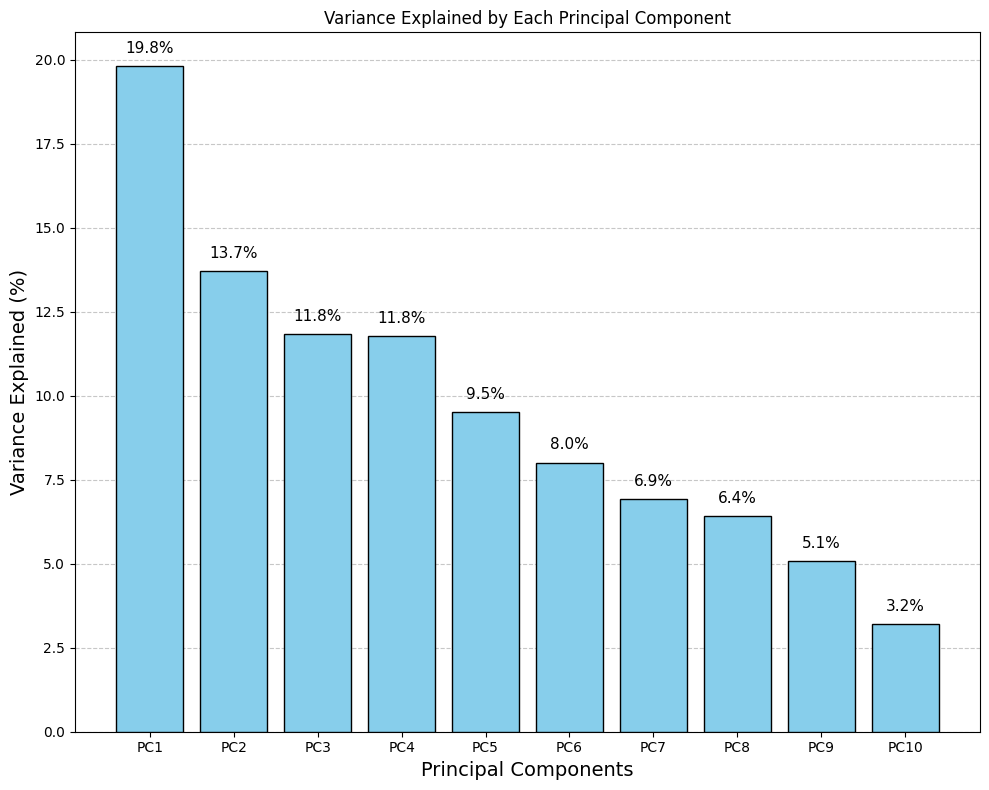

In [33]:
pca_variance = [19.82, 13.71, 11.82, 11.77, 9.50, 8.01, 6.92, 6.43, 5.09, 3.21]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()


In [40]:
loadings = pca.components_.T 

loading_df = pd.DataFrame(loadings, index=combined_df.columns, 
                          columns=[f'PC{i+1}' for i in range(loadings.shape[1])])


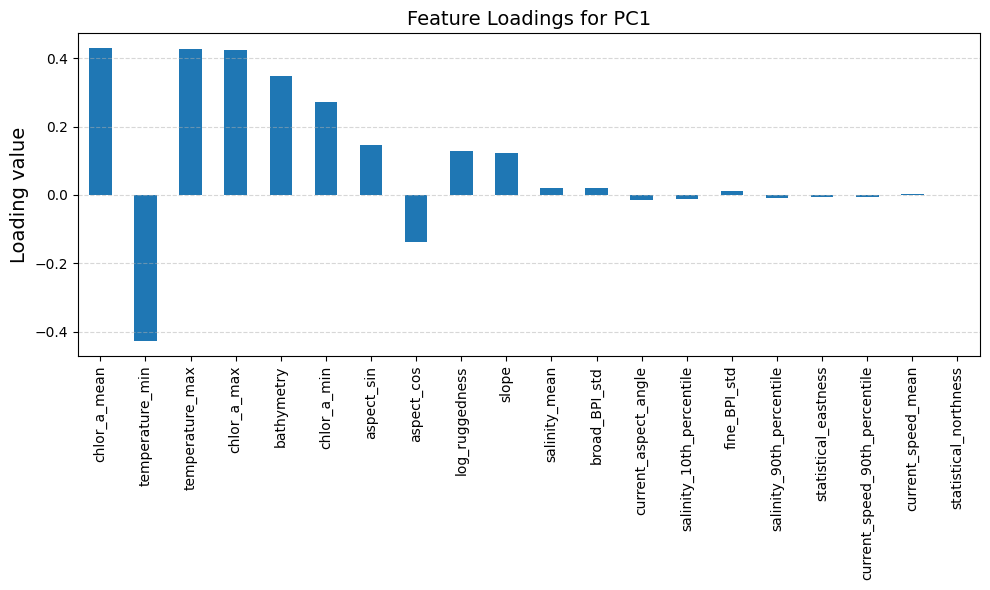

In [43]:
pc1_loadings = loading_df['PC1'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc1_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC1", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


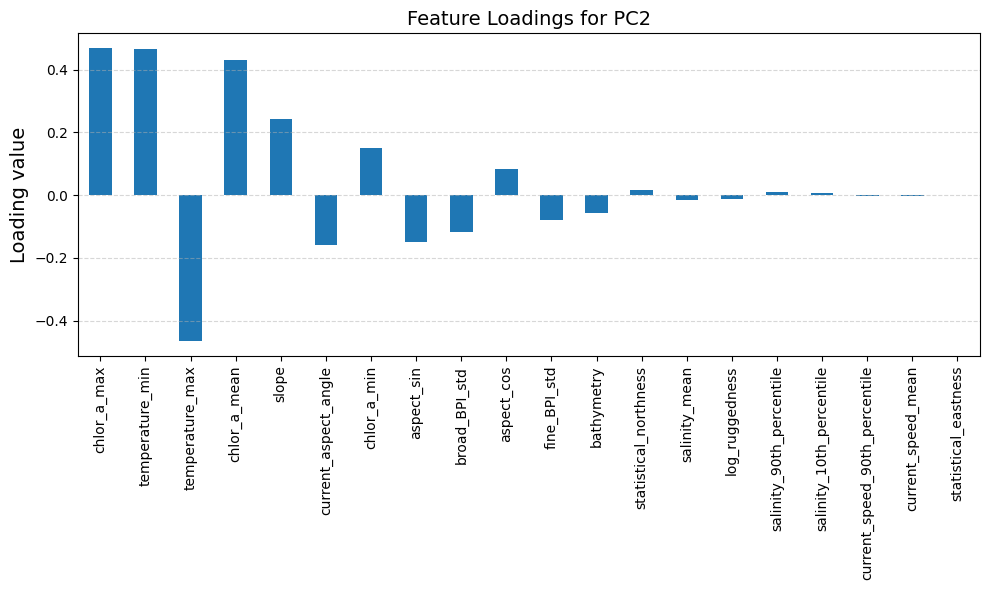

In [44]:
pc2_loadings = loading_df['PC2'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc2_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC2", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


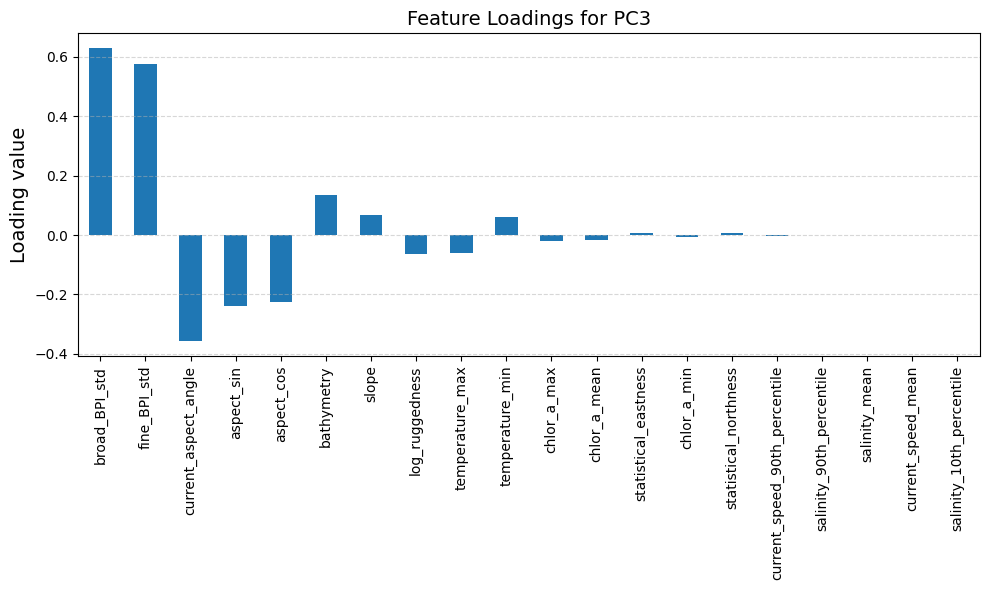

In [45]:
pc3_loadings = loading_df['PC3'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc3_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC3", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


PLS

In [47]:
X = combined_df
y = combined_df_no_nans[['labels']]

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, Y_train)

PLSRegression()

In [51]:
X_scores, Y_scores = pls.transform(X_train), pls.predict(X_train)

In [52]:
Y_train_pred = pls.predict(X_train)
Y_test_pred = pls.predict(X_test)

#Explained variance
print("X Loadings:", pls.x_loadings_)
print("Y Loadings:", pls.y_loadings_)

X Loadings: [[ 0.31363659 -0.195714  ]
 [ 0.20344757  0.40550257]
 [ 0.11652698  0.25570732]
 [ 0.10827779  0.16796777]
 [ 0.15612054  0.14740598]
 [-0.17186757 -0.17777851]
 [ 0.03454217 -0.31130023]
 [-0.42896848  0.10629348]
 [ 0.42896848 -0.10629348]
 [-0.26919456  0.24533117]
 [ 0.27500952 -0.36636804]
 [-0.19100201  0.32518627]
 [ 0.18564561 -0.1577272 ]
 [-0.12150942  0.08166724]
 [-0.06016784 -0.09184332]
 [ 0.091338    0.48177966]
 [-0.02409213 -0.01051108]
 [ 0.31426738 -0.19005621]
 [ 0.35617373 -0.22436755]
 [ 0.31422917 -0.19534411]]
Y Loadings: [[0.00296358 0.00203392]]


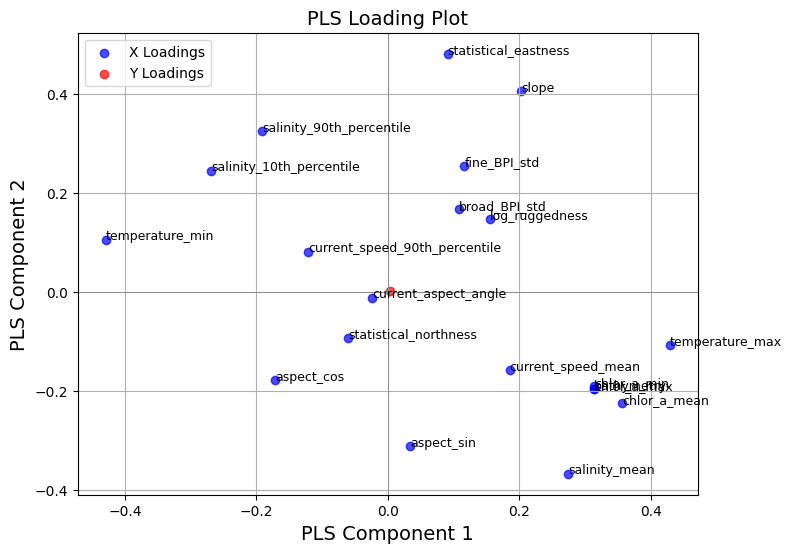

In [53]:
loadings_X = pls.x_loadings_
loadings_Y = pls.y_loadings_

plt.figure(figsize=(8, 6))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings', color='blue', alpha=0.7)
plt.scatter(loadings_Y[:, 0], loadings_Y[:, 1], label='Y Loadings', color='red', alpha=0.7)

for i, feature in enumerate(X_train.columns):
    plt.text(loadings_X[i, 0], loadings_X[i, 1], feature, fontsize=9)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PLS Component 1", fontsize=14)
plt.ylabel("PLS Component 2", fontsize=14)
plt.title("PLS Loading Plot", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

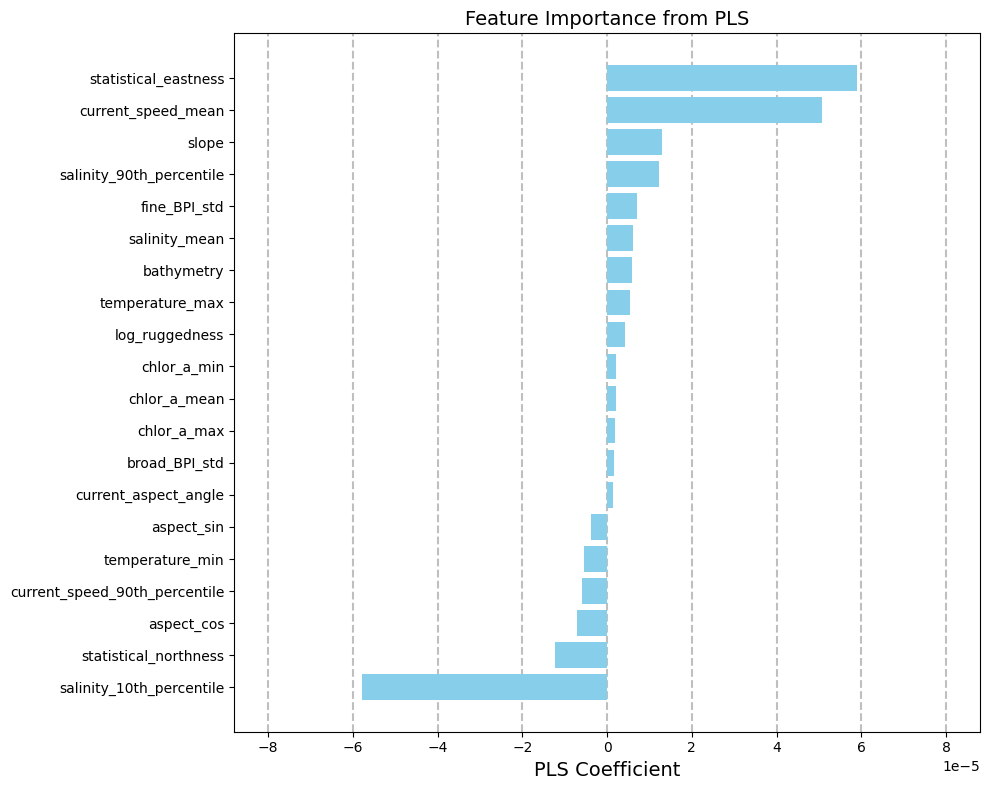

In [66]:
import matplotlib.pyplot as plt
import numpy as np

features = X.columns
coefficients = pls.coef_.ravel()

sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color="skyblue")
xticks = plt.xticks()[0]
for x in xticks:
    plt.axvline(x=x, linestyle='--', color='gray', alpha=0.5, zorder=0)
plt.title("Feature Importance from PLS", fontsize=14)
plt.xlabel("PLS Coefficient", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout() 
plt.show()